<a href="https://colab.research.google.com/github/mpasha7/VK_Data_Analysis/blob/main/API_VK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install vk

In [ ]:
import vk
from vk.exceptions import VkAPIError
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import time
from pprint import pprint
import random
import itertools
import sys
from datetime import datetime

In [ ]:
## Подключение к API VK
with open(f'config.yaml', 'r') as f:
  config = yaml.safe_load(f)

token = config['token']
version = config['version']
api = vk.API(access_token=token, v=version)

In [ ]:
## Функция для получения подписчиков сообщества
def fetch_members(group_id: str) -> list:
  try:
    members = api.groups.getMembers(group_id=group_id,
                                  fields='sex,bdate,country,city,occupation,universities',
                                  lang='ru')
  except:
    return []

  offset = 1000
  members_count = members['count']
  print(f"В группе {group_id} {members_count} подписчиков")
  members = members['items']

  while offset < members_count:
    members.extend(
        api.groups.getMembers(group_id=group_id,
                         fields='activity,sex,bdate',
                         count=1000,
                         offset=offset,
                         lang='ru')['items'])
    offset += 1000
    time.sleep(0.34)

  return members

In [ ]:
## Функция для ввода id/screen_name сообщества
def get_members(num):
  while True:
    group_id = input(f'Id или короткое имя {num} группы: ')
    members = fetch_members(group_id)
    if len(members) > 0:
      return members
    else:
      print('Нет доступа к подписчикам этой группы!')

In [ ]:
def get_members_groups(members):
  ## Список ID всех подписчиков с открытым аккаунтом
  ids_members = [
      members[i]['id'] for i in range(len(members))
      if members[i]['is_closed'] is False
  ]
  print(f"В группе {len(ids_members)} подписчиков c открытым аккаунтом")

  members_groups = {}

  while len(members_groups) < 1000:
    sample_ids_members = random.sample(ids_members, 1000 - len(members_groups))
    members_groups_part = {}
    drop_users = []
    error_count = 0

    for i in tqdm_notebook(sample_ids_members):
      try:
        members_groups_part[i] = api.users.getSubscriptions(user_id=i)['groups']['items']
        time.sleep(0.34)
      except VkAPIError as e:
        drop_users.append(i)
        error_count += 1
        print(f'Error {error_count}:', e.message)

    members_groups = {k: v for k, v in members_groups_part.items() if k not in drop_users}
    print(f"Забаненных пользователей: {len(drop_users)}")

  print(f"Получено {len(members_groups)} пользователей c их списками групп")
  return members_groups

In [ ]:
## ПЕРВАЯ ГРУППА
members1 = get_members(1)                      ## Все пользователи
members1_groups = get_members_groups(members1) ## Выборка 1000 пользователей со списками их групп

Id или короткое имя 1 группы: hsecouncil
В группе hsecouncil 11068 подписчиков
В группе 8060 подписчиков c открытым аккаунтом


<ipython-input-7-774b6cf9b8b4>:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(sample_ids_members):


  0%|          | 0/1000 [00:00<?, ?it/s]

Забаненных пользователей: 0
Получено 1000 пользователей c их списками групп


In [ ]:
## ВТОРАЯ ГРУППА
members2 = get_members(2)                      ## Все пользователи
members2_groups = get_members_groups(members2) ## Выборка 1000 пользователей со списками их групп

Id или короткое имя 2 группы: oduvanmem
В группе oduvanmem 9958 подписчиков
В группе 7615 подписчиков c открытым аккаунтом


<ipython-input-7-774b6cf9b8b4>:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(sample_ids_members):


  0%|          | 0/1000 [00:00<?, ?it/s]

Забаненных пользователей: 0
Получено 1000 пользователей c их списками групп


In [ ]:
## Распределение количества пользователей по месяцам рождения и возрасту
## Для выборки пользователей из 5000 (минус брак)
def get_counters(members):
  ## Пользователи с датой рождения
  members_with_bdate = list(
      filter(lambda  x: x.get('bdate'), members)
  )
  print(f'{len(members_with_bdate)} пользователей с датой рождения. ', end='')
  ## Выборка из 5000 пользователей с датой рождения
  members_with_bdate = random.sample(members_with_bdate, 5000)

  MONTHS_MAP = {1: 'Январь', 2: 'Февраль', 3: 'Март', 4: 'Апрель', 5: 'Май', 6: 'Июнь',
      7: 'Июль', 8: 'Август', 9: 'Сентябрь', 10: 'Октябрь', 11: 'Ноябрь', 12: 'Декабрь'
  }
  months_counter = {'Январь': 0, 'Февраль': 0, 'Март': 0, 'Апрель': 0, 'Май': 0,
      'Июнь': 0, 'Июль': 0, 'Август': 0, 'Сентябрь': 0, 'Октябрь': 0, 'Ноябрь': 0, 'Декабрь': 0
  }
  ages_counter = {}

  ## Собираем месяца рождения
  for m in members_with_bdate:
    try:
      dt = datetime.strptime(m['bdate'], '%d.%m.%Y')
      age = (datetime.now().year - dt.year) // 5 * 5
      if age in ages_counter:
        ages_counter[age] += 1
      else:
        ages_counter[age] = 1
    except:
      try:
        dt = datetime.strptime(m['bdate'], '%d.%m')
      except:
        continue

    month = MONTHS_MAP[dt.month]
    months_counter[month] += 1

  print(f'Обработано: {sum(months_counter.values())}')
  return {'months': months_counter, 'ages': ages_counter}

9297 пользователей с датой рождения. Обработано: 4998
8472 пользователей с датой рождения. Обработано: 5000


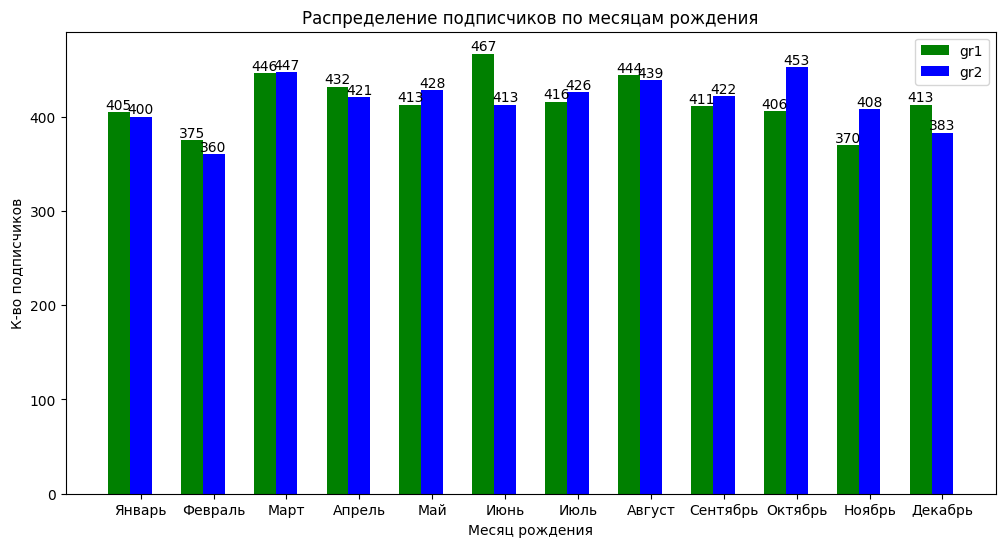

In [ ]:
## Визуализация по месяцам
counters1 = get_counters(members1)
counters2 = get_counters(members2)
months_counter1 = counters1['months']
months_counter2 = counters2['months']

fig, ax = plt.subplots(figsize=(12, 6))
plt.xlabel('Месяц рождения')
plt.ylabel('К-во подписчиков')
names = list(months_counter1.keys())
values1 = list(months_counter1.values())
values2 = list(months_counter2.values())
x = np.arange(len(names))
w = 0.3
bar_1 = ax.bar(x - w/2, values1, w, tick_label=names, label='gr1', color='green')
bar_2 = ax.bar(x + w/2, values2, w, tick_label=names, label='gr2', color='blue')
ax.bar_label(bar_1)
ax.bar_label(bar_2)

ax.set_title('Распределение подписчиков по месяцам рождения')
ax.legend()
plt.show()

In [ ]:
## Функция для выравнивания словарей по ключам
def leveling_dicts(dict1, dict2):
  for k, v in dict1.items():
    if k not in dict2:
      dict2[k] = 0
  for k, v in dict2.items():
    if k not in dict1:
      dict1[k] = 0

  return dict1, dict2

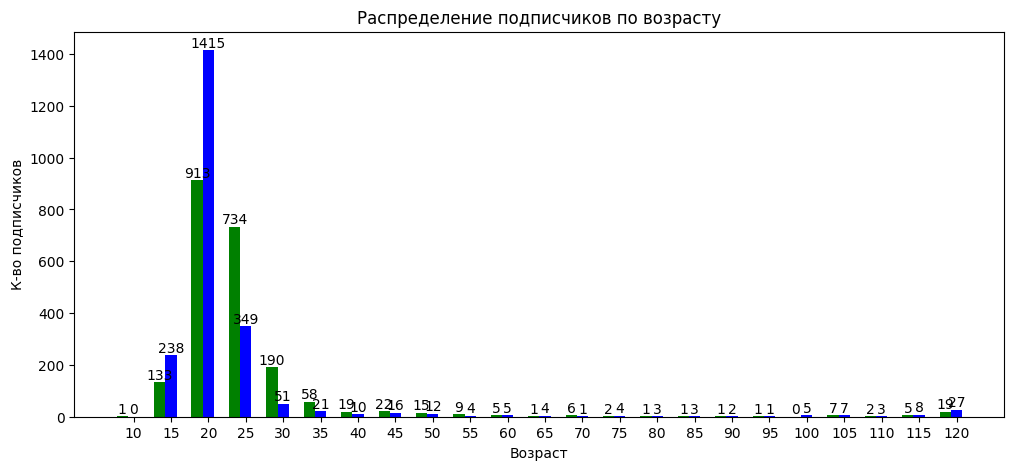

In [ ]:
## Визуализация по возрасту
ages_counter1 = counters1['ages']
ages_counter2 = counters2['ages']
ages_counter1, ages_counter2 = leveling_dicts(ages_counter1, ages_counter2)
## Сортировка
ages_list1 = sorted(ages_counter1.items(), key=lambda x: x[0])
ages_list2 = sorted(ages_counter2.items(), key=lambda x: x[0])

fig, ax = plt.subplots(figsize=(12, 5))
plt.xlabel('Возраст')
plt.ylabel('К-во подписчиков')
names = [t[0] for t in ages_list1]
values1 = [t[1] for t in ages_list1]
values2 = [t[1] for t in ages_list2]
x = np.arange(len(names))
w = 0.3
bar_1 = ax.bar(x - w/2, values1, w, tick_label=names, label='gr1', color='green')
bar_2 = ax.bar(x + w/2, values2, w, tick_label=names, label='gr2', color='blue')
ax.bar_label(bar_1)
ax.bar_label(bar_2)

ax.set_title('Распределение подписчиков по возрасту')
plt.show()

In [ ]:
## Странности с датой рождения
for m in members1:
  try:
    dt = datetime.strptime(m['bdate'], '%d.%m.%Y')
    if dt.year < 1930:
      print(dt.year)
  except:
    continue

1905
1917
1911
1904
1901
1906
1905
1901
1911
1902
1920
1917
1902
1916
1916
1903
1910
1902
1919
1902
1901
1902
1902
1903
1902
1903
1902
1918
1903
1917
1919
1907
1902
1916
1902
1902
1902
1901
1902
1905
1910
1906
1903
1918
1906
1902
1917
1902
1903
1903
1911
1907
1902
1917
1910
1906
1901
1917
1902
1902
1917
1913
1902
1903
1905
1911
1901
1915
1917
1914
1927
1901
1907
1901
1905
1912
1901


In [ ]:
## Распределение по полу
def get_genders(members):
  GENDER = {
      1: 'female',
      2: 'male'
  }
  result_gender = {'female': 0, 'male': 0}

  for m in members:
      gender = m.get('sex')
      name_gender = GENDER.get(gender)
      if name_gender:
          result_gender[name_gender] += 1

  return result_gender

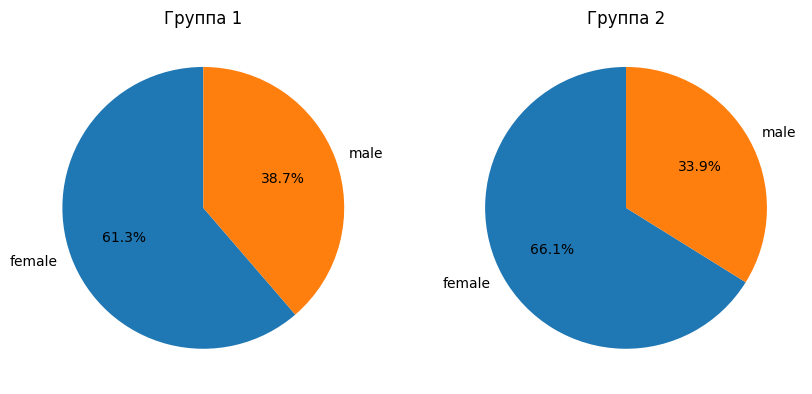

In [ ]:
genders1 = get_genders(members1)
genders2 = get_genders(members2)

plt.rcParams["figure.figsize"] = 10, 6

plt.subplot(1, 2, 1)
plt.title('Группа 1')
plt.pie(genders1.values(), labels=genders1.keys(), startangle=90, autopct='%1.1f%%')

plt.subplot(1, 2, 2)
plt.title('Группа 2')
plt.pie(genders2.values(), labels=genders2.keys(), startangle=90, autopct='%1.1f%%')
plt.show()

In [ ]:
## ПЕРЕСЕЧЕНИЕ
df_members1 = pd.json_normalize(members1)
df_members2 = pd.json_normalize(members2)
intersection = pd.merge(df_members1, df_members2, how='inner', on=['id'])
len(intersection)

6

In [ ]:
intersection

,id,bdate_x,sex_x,first_name_x,last_name_x,can_access_closed_x,is_closed_x,city.id_x,city.title_x,country.id_x,...,country.title_y,occupation.id_y,occupation.name_y,occupation.type_y,occupation.graduate_year_y,occupation.country_id_y,occupation.city_id_y,deactivated_y,universities_y,activity_y
0,166071253,1.2,2,Данил,Федосеев,False,True,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Nitimur in vetitum semper, cupimusque negata"
1,225853156,2.10.2003,2,Игорь,Лукин,True,False,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Look in Lukin
2,236627753,3.8.2001,2,Илья,Митрофанов,True,False,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
3,323169166,16.11.2004,1,Светлана,Альбах,True,False,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
4,324679027,NaN,1,Анна,Ильичева,False,True,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
5,587041732,31.1.2000,1,Софья,Набалова,True,False,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Живи и ошибайся. В этом жизнь.


In [ ]:
## Переставим ключи и значения
## Для каждой группы получим список пользователей
dict_group_members = {}

for key, values in members1_groups.items():
  for value in values:
    dict_group_members.setdefault(value, set()).add(key)

for key, values in members2_groups.items():
  for value in values:
    dict_group_members.setdefault(value, set()).add(key)

print(len(dict_group_members))

## TEST
for k, v in dict_group_members.items():
  if k == 64952366 or k == 186468555:
    print(f'{k} -> {len(v)} подписчиков')

113534
64952366 -> 995 подписчиков
186468555 -> 994 подписчиков


In [ ]:
## Выберем только те группы, где пересечений с начальной группой больше 100
dict_group_members_more = {
    i: dict_group_members[i]
    for i in dict_group_members.keys() if (len(dict_group_members[i])) > 150
}

# del_elems = []
# for i in dict_group_members_more:
#   for j in dict_group_members_more:
#     if len(dict_group_members_more[i] & dict_group_members_more[j]) == 0:
#       del_elems.append(j)

# dict_group_members_more = {k: v for k, v in dict_group_members_more.items() if k not in del_elems}

len(dict_group_members_more.keys())

72

In [ ]:
## Получим названия и топики групп
# from pprint import pprint
name_groups = {}
topic_groups = {}

for key, value in tqdm_notebook(dict_group_members_more.items()):
  info_group = api.groups.getById(group_id=key, fields='activity', lang='ru')[0]
  # pprint(info_group)
  name_groups[key] = info_group['name']
  topic_groups[key] = info_group['activity']
  time.sleep(0.34)

<ipython-input-39-b5a997d096ad>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for key, value in tqdm_notebook(dict_group_members_more.items()):


  0%|          | 0/72 [00:00<?, ?it/s]

In [ ]:
## Количество пользователей в каждой группе
members_counts = {
    group: len(dict_group_members_more[group])
    for group in dict_group_members_more
}

In [ ]:
## Словарь с информацией по пересечениям пользователей между сообществами
## Матрица смежности
adjacency_matrix = {}

for i in dict_group_members_more:
  for j in dict_group_members_more:
    if i != j:
      # нормирование
      # if len(dict_group_members_more[i] & dict_group_members_more[j]) != 0:
      adjacency_matrix[i+j] = 1 / (len(dict_group_members_more[i] & dict_group_members_more[j]) + 0.25)

In [ ]:
!pip install netgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.7/96.7 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.6/305.6 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 4.3 MB/s eta 0:00:00


In [ ]:
import networkx as nx
from netgraph import Graph

In [ ]:
## Неориентированный граф
G = nx.Graph()

for i in dict_group_members_more:
  ## создаем узел - ID сообщества
  G.add_node(i)

  for j in dict_group_members_more:
    ## добавляем ребра - связи между узлами
    if i != j:
      G.add_edge(i, j, weight=adjacency_matrix[i+j])

In [ ]:
## Добавляем атрибуты - имя и топики
nx.set_node_attributes(G, name_groups, 'name')
nx.set_node_attributes(G, topic_groups, 'topic')

In [ ]:
## Получаем тематики канала
node_to_group = nx.get_node_attributes(G, 'topic')

## Количество неповторяющихся топиков
n_topics = len(set(node_to_group.values()))
## Цветовая схема
cmap = sns.color_palette("RdBu_r", n_topics)
## Цвета топиков
group_to_color = {
    key: cmap.as_hex()[num]
    for num, key in enumerate(set(node_to_group.values()))
}
## Сопоставляем цвет-топик-id группы
node_color = {
    group_id: group_to_color[topic] \
    for group_id, topic in node_to_group.items()
}
## Размер узла
node_size = {
    key: value / 100
    for key, value in members_counts.items()
}
## Размер ребра
edge_width = {}
edge_width = {
    key: value / 5
    for key, value in nx.get_edge_attributes(G, 'weight').items()
}
## Названия узлов
node_labels = nx.get_node_attributes(G, 'name')

In [ ]:
topic_counter = {}
for k, v in node_to_group.items():
  if v in topic_counter:
    topic_counter[v] += 1
  else:
    topic_counter[v] = 1

topic_counter

{'Интернет-СМИ': 8,
 'Юмор': 23,
 'Образование': 4,
 'Городское сообщество': 5,
 'ВКонтакте': 1,
 'Университет': 2,
 'Бизнес': 2,
 'Издательский дом': 1,
 'Туризм, путешествия': 1,
 'Блог': 1,
 'Дискуссионный клуб': 1,
 'Астрология, эзотерика': 1,
 'Кино': 2,
 'Культурный центр': 1,
 'Блогер': 1,
 'Творчество': 3,
 'Фан-сообщество': 1,
 'Парк отдыха': 1,
 'Фотография': 1,
 'Литература': 4,
 'Финансы': 1,
 'Знакомства': 1,
 'Наука': 1,
 'Государственная организация': 1,
 'Молодёжное движение': 1,
 'Шоу, передача': 1,
 'Печать, полиграфия': 1,
 'Культура': 1}

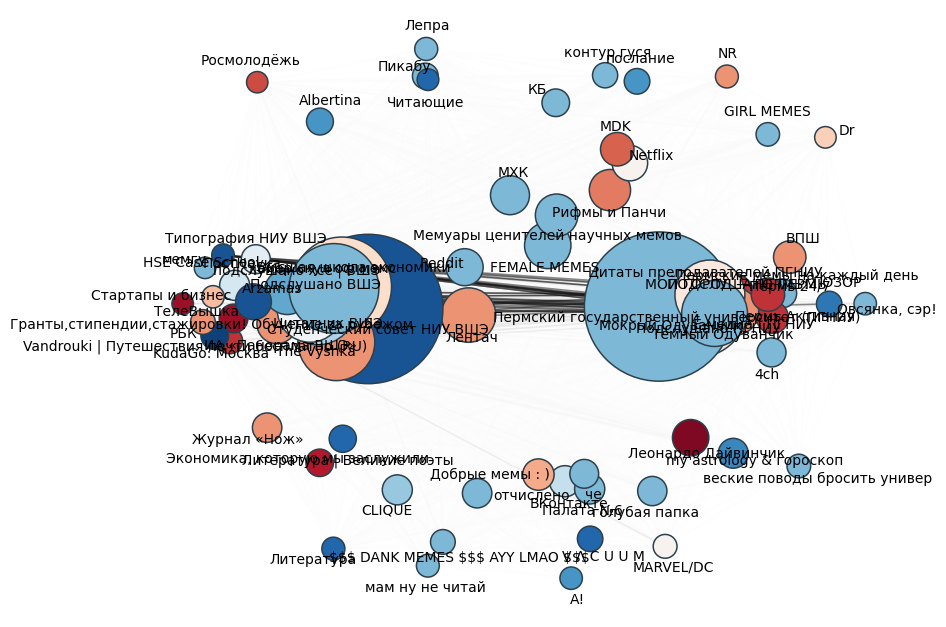

In [ ]:
## Близость групп по пересечению множества подписчиков
fig, ax = plt.subplots(figsize=(10, 10))

Graph(
    G,
    node_size=node_size,
    node_color=node_color,
    node_labels=node_labels,
    node_label_offset=0.03,
    node_edge_width=0.2,
    edge_width=0.2,
    edge_alpha=0.5,
    node_layout='geometric',
    node_layout_kwargs=dict(edge_length=edge_width),
    ax=ax
)
plt.show()

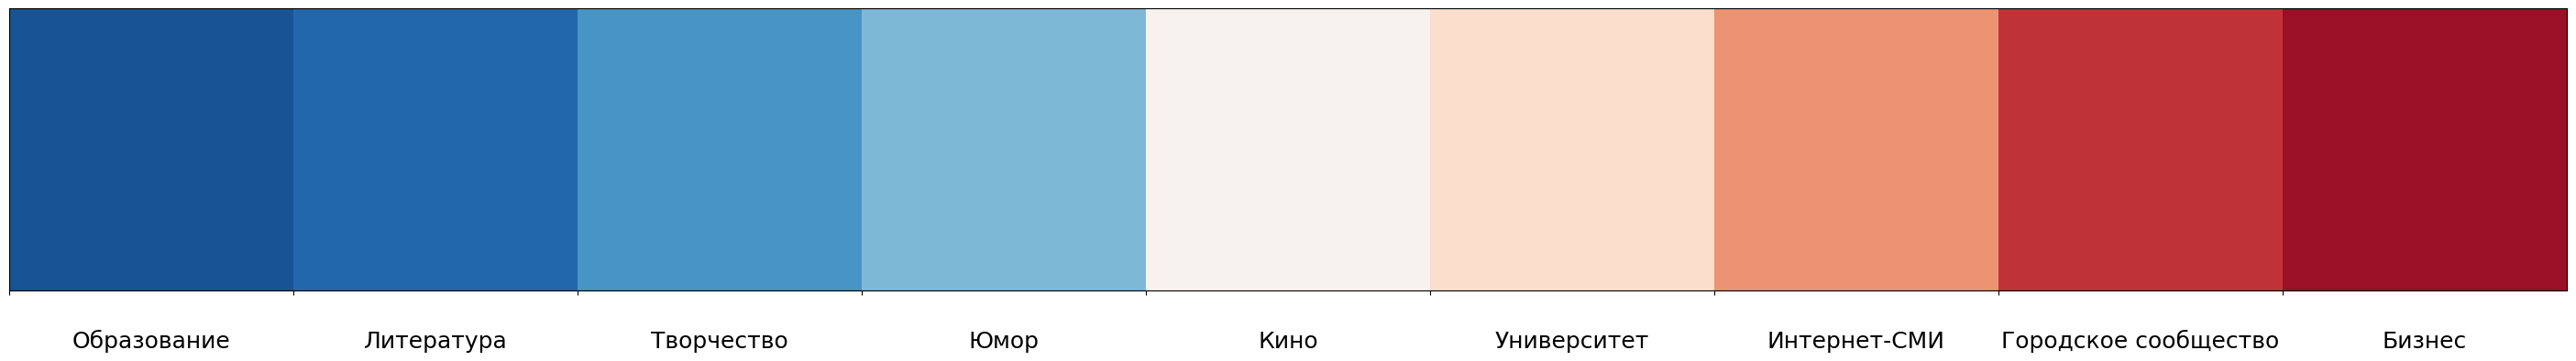

In [ ]:
## Палитра
group_to_color_selected = {key: value for key, value in group_to_color.items() if topic_counter[key] > 1}
sns.palplot({value: key for key, value in group_to_color.items() if topic_counter[key] > 1}, size=4)
ax = plt.gca()
for i, name in enumerate(group_to_color_selected):
  ax.text(i, 0.7, name, horizontalalignment='center', size=18, color='black')

/usr/local/lib/python3.10/dist-packages/netgraph/_edge_layout.py:978: RuntimeWarning: invalid value encountered in divide
  displacement = compatibility * delta / distance_squared[..., None]


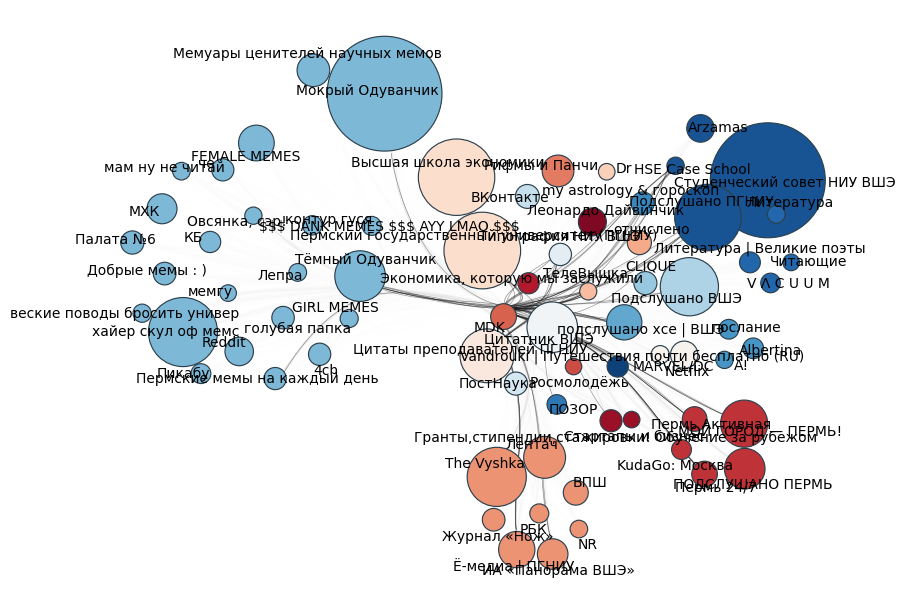

In [ ]:
## Посмотрим на выделенные комьюнити
fig, ax = plt.subplots(figsize=(10, 10))

Graph(
    G,
    node_color=node_color,
    node_edge_width=0.2,
    edge_width=0.1,
    edge_alpha=0.5,
    node_size=node_size,
    node_labels=node_labels,
    node_label_offset=0.03,
    node_layout='community',
    node_layout_kwargs=dict(node_to_community=node_to_group),
    edge_layout='bundled',
    ax=ax
)